In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import KFold, GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

random_seed = 2024
best_params = {}

param_grid = {
    'RF': {'n_estimators': [50, 75, 100, 200, 300, 400], 'max_depth': [None, 5, 10, 15, 20]},
    'GB': {'n_estimators': [50, 75, 100, 200, 300, 400], 'max_depth': [None, 5, 10, 15, 20]},
    'KNN': {'n_neighbors': [5, 10, 15], 'leaf_size': [25, 30, 35]},
    'DT': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 4, 6]},
    'SVR': {'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto', 0.1, 1, 10]}, 
    'BG': {'n_estimators': [50, 75, 100, 200, 300, 400]},
    'ET': {'n_estimators': [50, 75, 100, 200, 300, 400], 'max_depth': [None, 5, 10, 15, 20]}
}

models = {
    "RF": RandomForestRegressor(n_jobs=-1, random_state=random_seed),
    "GB": GradientBoostingRegressor(random_state=random_seed),
    "KNN": KNeighborsRegressor(n_jobs=-1),
    "DT": DecisionTreeRegressor(random_state=random_seed),
    "SVR": SVR(),
    "BG": BaggingRegressor(n_jobs=-1, random_state=random_seed),
    "ET": ExtraTreesRegressor(n_jobs=-1, random_state=random_seed),
}

kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)

directory = "./result"

datasets = {
    'MF': 'MF-red.npz',
    'MACCS': 'MACCS-red.npz',
    'PhO': 'PhO-red.npz',
    'rdkit': 'rdkit-red.npz',
    'PhO_rdkit': 'PhO_rdkit.npz',
    'PhO_maccs': 'PhO_maccs.npz',
    'PhO_MF': 'PhO_MF.npz',
    'rdkit_maccs': 'rdkit_maccs.npz',
    'PhO_rdkit_maccs': 'PhO_rdkit_maccs.npz'
    
}

test_index = [87, 381, 316, 120, 479, 448, 197, 507, 198, 379, 508, 313, 265, 449, 453, 89, 292, 88, 121, 266, 454, 455, 447, 456, 271, 
              269, 294, 293, 297, 248, 249, 464, 312, 499, 289, 509, 511, 267, 166, 386, 290, 392, 498, 91, 488, 7, 278, 54, 285, 94, 303, 
              358, 444, 5, 286, 98, 458, 2, 291, 268, 470, 262, 308, 272, 53, 354, 512, 360, 495, 468, 391, 310, 307, 457, 306, 258, 352, 
              305, 357, 131, 362, 42, 311, 460, 304, 510, 298, 263, 350, 368, 100, 115, 61, 500, 56, 90, 442, 277, 487, 309, 0, 1, 356]

External_index = [462,119 ,396, 273, 375, 503, 318, 504, 472, 463, 465, 341, 342, 340, 477, 327, 348, 476,423 ,377, 332, 333, 182, 181,
                  349, 183, 112, 328, 323, 324, 113, 329, 330, 331, 144, 145,149, 150, 153, 151, 152, 154, 147, 485, 148, 482, 370, 373,
                  372, 146, 371]

for desc_name, file_path in datasets.items():
    full_path = os.path.join(directory, file_path)
    if os.path.exists(full_path):
        with np.load(full_path, allow_pickle=True) as npz_file:
            array_data = npz_file['data']
            columns = npz_file['columns']
            df = pd.DataFrame(array_data, columns=columns)

            all_indices = set(range(len(df)))  
            train_val_indices = sorted(list(all_indices - set(test_index) - set(External_index)))
            X = df.drop(columns=['YRed/Ox', 'compound_name'])
            y = df['YRed/Ox']

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X.iloc[train_val_indices])
            y_train_val = y.iloc[train_val_indices]

            for model_name, model in models.items():
                if model_name in param_grid:
                    GS = GridSearchCV(model, param_grid[model_name], cv=kfold, n_jobs=-1, scoring='r2')
                    GS.fit(X_scaled, y_train_val)
                    best_score = GS.best_score_
                    best_param = GS.best_params_
                    best_params[(model_name, desc_name)] = best_param
                    print(f"Dataset: {desc_name}, Model: {model_name}, Best Score: {best_score:.4f}, Best Params: {best_param}")


Dataset: MF, Model: RF, Best Score: 0.6576, Best Params: {'max_depth': 15, 'n_estimators': 100}
Dataset: MF, Model: GB, Best Score: 0.6507, Best Params: {'max_depth': 5, 'n_estimators': 400}
Dataset: MF, Model: KNN, Best Score: 0.3483, Best Params: {'leaf_size': 25, 'n_neighbors': 5}
Dataset: MF, Model: DT, Best Score: 0.4378, Best Params: {'max_depth': 20, 'min_samples_split': 6}
Dataset: MF, Model: SVR, Best Score: 0.5037, Best Params: {'gamma': 'auto', 'kernel': 'rbf'}
Dataset: MF, Model: BG, Best Score: 0.6503, Best Params: {'n_estimators': 100}
Dataset: MF, Model: ET, Best Score: 0.4845, Best Params: {'max_depth': 10, 'n_estimators': 50}
Dataset: MACCS, Model: RF, Best Score: 0.7050, Best Params: {'max_depth': 15, 'n_estimators': 300}
Dataset: MACCS, Model: GB, Best Score: 0.6801, Best Params: {'max_depth': 5, 'n_estimators': 75}
Dataset: MACCS, Model: KNN, Best Score: 0.2694, Best Params: {'leaf_size': 25, 'n_neighbors': 5}
Dataset: MACCS, Model: DT, Best Score: 0.5054, Best Para

/datapool/home/2022900019/.lico_env/jupyter/env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Dataset: PhO_MF, Model: ET, Best Score: 0.9364, Best Params: {'max_depth': 20, 'n_estimators': 200}
Dataset: rdkit_maccs, Model: RF, Best Score: 0.7578, Best Params: {'max_depth': 15, 'n_estimators': 200}
Dataset: rdkit_maccs, Model: GB, Best Score: 0.7757, Best Params: {'max_depth': 5, 'n_estimators': 200}
Dataset: rdkit_maccs, Model: KNN, Best Score: 0.4548, Best Params: {'leaf_size': 25, 'n_neighbors': 5}
Dataset: rdkit_maccs, Model: DT, Best Score: 0.5598, Best Params: {'max_depth': 10, 'min_samples_split': 6}
Dataset: rdkit_maccs, Model: SVR, Best Score: 0.6867, Best Params: {'gamma': 'auto', 'kernel': 'rbf'}
Dataset: rdkit_maccs, Model: BG, Best Score: 0.7592, Best Params: {'n_estimators': 400}


/datapool/home/2022900019/.lico_env/jupyter/env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Dataset: rdkit_maccs, Model: ET, Best Score: 0.7844, Best Params: {'max_depth': None, 'n_estimators': 400}
Dataset: PhO_rdkit_maccs, Model: RF, Best Score: 0.9182, Best Params: {'max_depth': None, 'n_estimators': 400}
Dataset: PhO_rdkit_maccs, Model: GB, Best Score: 0.9208, Best Params: {'max_depth': 5, 'n_estimators': 400}
Dataset: PhO_rdkit_maccs, Model: KNN, Best Score: 0.7042, Best Params: {'leaf_size': 25, 'n_neighbors': 5}
Dataset: PhO_rdkit_maccs, Model: DT, Best Score: 0.8318, Best Params: {'max_depth': None, 'min_samples_split': 4}
Dataset: PhO_rdkit_maccs, Model: SVR, Best Score: 0.8918, Best Params: {'gamma': 'scale', 'kernel': 'linear'}
Dataset: PhO_rdkit_maccs, Model: BG, Best Score: 0.9177, Best Params: {'n_estimators': 400}


/datapool/home/2022900019/.lico_env/jupyter/env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Dataset: PhO_rdkit_maccs, Model: ET, Best Score: 0.9397, Best Params: {'max_depth': 20, 'n_estimators': 400}


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from itertools import product

params = {'n_estimators': [50,75,100,200,300,400],'max_depth': [None, 5, 10, 15, 20]}

for desc_name, file_path in datasets.items():
    full_path = os.path.join(directory, file_path)
    if os.path.exists(full_path):
        with np.load(full_path, allow_pickle=True) as npz_file:
            data = npz_file['data']
            columns = npz_file['columns']
            df = pd.DataFrame(data, columns=columns)

            all_indices = set(range(len(df)))
            train_val_indices = sorted(list(all_indices - set(test_index) - set(External_index))) 

            X = df.drop(columns=['YRed/Ox', 'compound_name'])
            y = df['YRed/Ox']

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X.iloc[train_val_indices])
            y_train_val = y.iloc[train_val_indices]
            result = []

            for n_estimators, max_depth in product(params['n_estimators'], params['max_depth']):
                model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=random_seed)
                all_test_p = []
                all_test_y = []
                for train_idx, test_idx in kfold.split(X_scaled, y_train_val):
                    train_x, test_x = X_scaled[train_idx], X_scaled[test_idx]
                    train_y, test_y = y_train_val.iloc[train_idx], y_train_val.iloc[test_idx]
                    model.fit(train_x, train_y)
                    all_test_p.append(model.predict(test_x))
                    all_test_y.append(test_y)
                all_test_p = np.concatenate(all_test_p,axis=0)
                all_test_y = np.concatenate(all_test_y,axis=0)
                mae = mean_absolute_error(all_test_y,all_test_p)
                r2 = r2_score(all_test_y,all_test_p)
                result.append([n_estimators,max_depth,mae,r2])
                
            best_result = sorted(result,key=lambda x: x[3], reverse=True)[0]
            best_param = {'n_estimators':best_result[0],'max_depth':best_result[1]}
            best_params[('XGB', desc_name)] = best_param
            print(f'Model: XGB, Dataset: {desc_name}, Best R2 Score: {best_result[3]:.4f}, Best Param: {best_param}')

Model: XGB, Dataset: MF, Best R2 Score: 0.6373, Best Param: {'n_estimators': 75, 'max_depth': None}
Model: XGB, Dataset: MACCS, Best R2 Score: 0.7100, Best Param: {'n_estimators': 50, 'max_depth': None}
Model: XGB, Dataset: PhO, Best R2 Score: 0.9248, Best Param: {'n_estimators': 75, 'max_depth': 5}
Model: XGB, Dataset: rdkit, Best R2 Score: 0.6891, Best Param: {'n_estimators': 50, 'max_depth': 5}
Model: XGB, Dataset: PhO_rdkit, Best R2 Score: 0.9258, Best Param: {'n_estimators': 200, 'max_depth': 5}
Model: XGB, Dataset: PhO_maccs, Best R2 Score: 0.9207, Best Param: {'n_estimators': 50, 'max_depth': None}
Model: XGB, Dataset: PhO_MF, Best R2 Score: 0.9206, Best Param: {'n_estimators': 200, 'max_depth': 5}
Model: XGB, Dataset: rdkit_maccs, Best R2 Score: 0.7341, Best Param: {'n_estimators': 75, 'max_depth': 5}
Model: XGB, Dataset: PhO_rdkit_maccs, Best R2 Score: 0.9252, Best Param: {'n_estimators': 50, 'max_depth': None}


In [3]:
best_params

{('RF', 'MF'): {'max_depth': 15, 'n_estimators': 100},
 ('GB', 'MF'): {'max_depth': 5, 'n_estimators': 400},
 ('KNN', 'MF'): {'leaf_size': 25, 'n_neighbors': 5},
 ('DT', 'MF'): {'max_depth': 20, 'min_samples_split': 6},
 ('SVR', 'MF'): {'gamma': 'auto', 'kernel': 'rbf'},
 ('BG', 'MF'): {'n_estimators': 100},
 ('ET', 'MF'): {'max_depth': 10, 'n_estimators': 50},
 ('RF', 'MACCS'): {'max_depth': 15, 'n_estimators': 300},
 ('GB', 'MACCS'): {'max_depth': 5, 'n_estimators': 75},
 ('KNN', 'MACCS'): {'leaf_size': 25, 'n_neighbors': 5},
 ('DT', 'MACCS'): {'max_depth': 10, 'min_samples_split': 4},
 ('SVR', 'MACCS'): {'gamma': 'auto', 'kernel': 'rbf'},
 ('BG', 'MACCS'): {'n_estimators': 400},
 ('ET', 'MACCS'): {'max_depth': 5, 'n_estimators': 75},
 ('RF', 'PhO'): {'max_depth': 15, 'n_estimators': 400},
 ('GB', 'PhO'): {'max_depth': 5, 'n_estimators': 400},
 ('KNN', 'PhO'): {'leaf_size': 25, 'n_neighbors': 5},
 ('DT', 'PhO'): {'max_depth': 10, 'min_samples_split': 6},
 ('SVR', 'PhO'): {'gamma': 's

In [4]:
np.save('./result/hyperparameters_10_opt_new.npy',best_params)

# Evaluate Different Combinations of ML Model and Descriptor at 10-Fold Cross-Validation

# Perform model training and validation

In [5]:
best_params = np.load('./result/hyperparameters_10_opt_new.npy',allow_pickle=True).item()

In [6]:
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from scipy.stats import pearsonr
from sklearn.feature_selection import RFECV
import seaborn as sns
import matplotlib.pyplot as plt
import inspect 

def initialize_model(model_name, custom_params=None, random_state=None):
    """
    Initialize various regression models with optional custom parameters and random state.
    
    Args:
    model_name (str): The name of the model to initialize.
    custom_params (dict, optional): Custom parameters for the model.
    random_state (int, optional): Random seed for reproducibility, defaults to None.

    Returns:
    model: Initialized model object.
    """
    model_defaults = {
        'RF': RandomForestRegressor,
        'GB': GradientBoostingRegressor,
        'KNN': KNeighborsRegressor,
        'DT': DecisionTreeRegressor,
        'SVR': SVR,
        'BG': BaggingRegressor,
        'ET': ExtraTreesRegressor,
        'BR': BayesianRidge,
        'Ridge': Ridge,
        'XGB': XGBRegressor
    }

    model_class = model_defaults.get(model_name)
    if not model_class:
        raise ValueError(f"{model_name} is not a valid model name.")

    # Prepare parameters to initialize the model
    params = custom_params if custom_params else {}
    if 'random_state' in inspect.signature(model_class).parameters:
        params['random_state'] = random_state

    # Initialize and return the model
    return model_class(**params)


In [7]:
model_names = ['RF', 'GB', 'KNN', 'DT', 'SVR', 'BG', 'ET', 'BR',  'Ridge', 'XGB']
kfold = KFold(n_splits=10,shuffle=True,random_state=random_seed)
performance_result = {}

for model_name in model_names:

    model_params = best_params.get(model_name)

    model = initialize_model(model_name, model_params,random_state=random_seed)
    for desc_name, file_path in datasets.items():
        full_path = os.path.join(directory, file_path)
        if os.path.exists(full_path):
            with np.load(full_path, allow_pickle=True) as npz_file:
                data = npz_file['data']
                columns = npz_file['columns']
                df = pd.DataFrame(data, columns=columns)
                all_indices = set(range(len(df)))
                train_val_indices = sorted(list(all_indices - set(test_index) - set(External_index))) 

                X, y = df.drop(columns=['YRed/Ox', 'compound_name']), df['YRed/Ox']
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X.iloc[train_val_indices])
                y_train_val = y.iloc[train_val_indices]
                all_test_p = []
                all_test_y = []
                for train_idx, test_idx in kfold.split(X_scaled, y_train_val):
                    train_x, test_x = X_scaled[train_idx], X_scaled[test_idx]
                    train_y, test_y = y_train_val.iloc[train_idx], y_train_val.iloc[test_idx]
                    test_P = []
                    for try_ in range(10): 
                        model.fit(train_x,train_y)
                        test_p = model.predict(test_x)
                        test_P.append(test_p)
                    test_p = np.mean(test_P,axis=0)
                    all_test_p.append(test_p)
                    all_test_y.append(test_y)
                all_test_p = np.concatenate(all_test_p)
                all_test_y = np.concatenate(all_test_y)
                mae = mean_absolute_error(all_test_y,all_test_p)
                r2 = r2_score(all_test_y,all_test_p)
                pearson_r,_ = pearsonr(all_test_y,all_test_p)
                performance_result[(model_name,desc_name)] = [mae,r2,pearson_r,all_test_y,all_test_p]
                print('Model: %4s, Desc: %4s, R2: %.4f, PearsonR: %.4f, MAE: %.4f'%(model_name,desc_name,r2,pearson_r,mae))


Model:   RF, Desc:   MF, R2: 0.6552, PearsonR: 0.8135, MAE: 0.1478
Model:   RF, Desc: MACCS, R2: 0.7049, PearsonR: 0.8422, MAE: 0.1471
Model:   RF, Desc:  PhO, R2: 0.9151, PearsonR: 0.9567, MAE: 0.0812
Model:   RF, Desc: rdkit, R2: 0.7002, PearsonR: 0.8419, MAE: 0.1472
Model:   RF, Desc: PhO_rdkit, R2: 0.9209, PearsonR: 0.9598, MAE: 0.0794
Model:   RF, Desc: PhO_maccs, R2: 0.9163, PearsonR: 0.9574, MAE: 0.0807
Model:   RF, Desc: PhO_MF, R2: 0.9142, PearsonR: 0.9562, MAE: 0.0817
Model:   RF, Desc: rdkit_maccs, R2: 0.7542, PearsonR: 0.8708, MAE: 0.1367
Model:   RF, Desc: PhO_rdkit_maccs, R2: 0.9208, PearsonR: 0.9597, MAE: 0.0792
Model:   GB, Desc:   MF, R2: 0.6345, PearsonR: 0.8067, MAE: 0.1799
Model:   GB, Desc: MACCS, R2: 0.6911, PearsonR: 0.8315, MAE: 0.1590
Model:   GB, Desc:  PhO, R2: 0.9265, PearsonR: 0.9628, MAE: 0.0793
Model:   GB, Desc: rdkit, R2: 0.7328, PearsonR: 0.8576, MAE: 0.1454
Model:   GB, Desc: PhO_rdkit, R2: 0.9334, PearsonR: 0.9662, MAE: 0.0750
Model:   GB, Desc: PhO_

In [8]:
np.save('./result/models_descs_screening_10_fold_new.npy',performance_result)

# Visualization

In [9]:
performance_result = np.load('./result/models_descs_screening_10_fold_new.npy',allow_pickle=True).item()

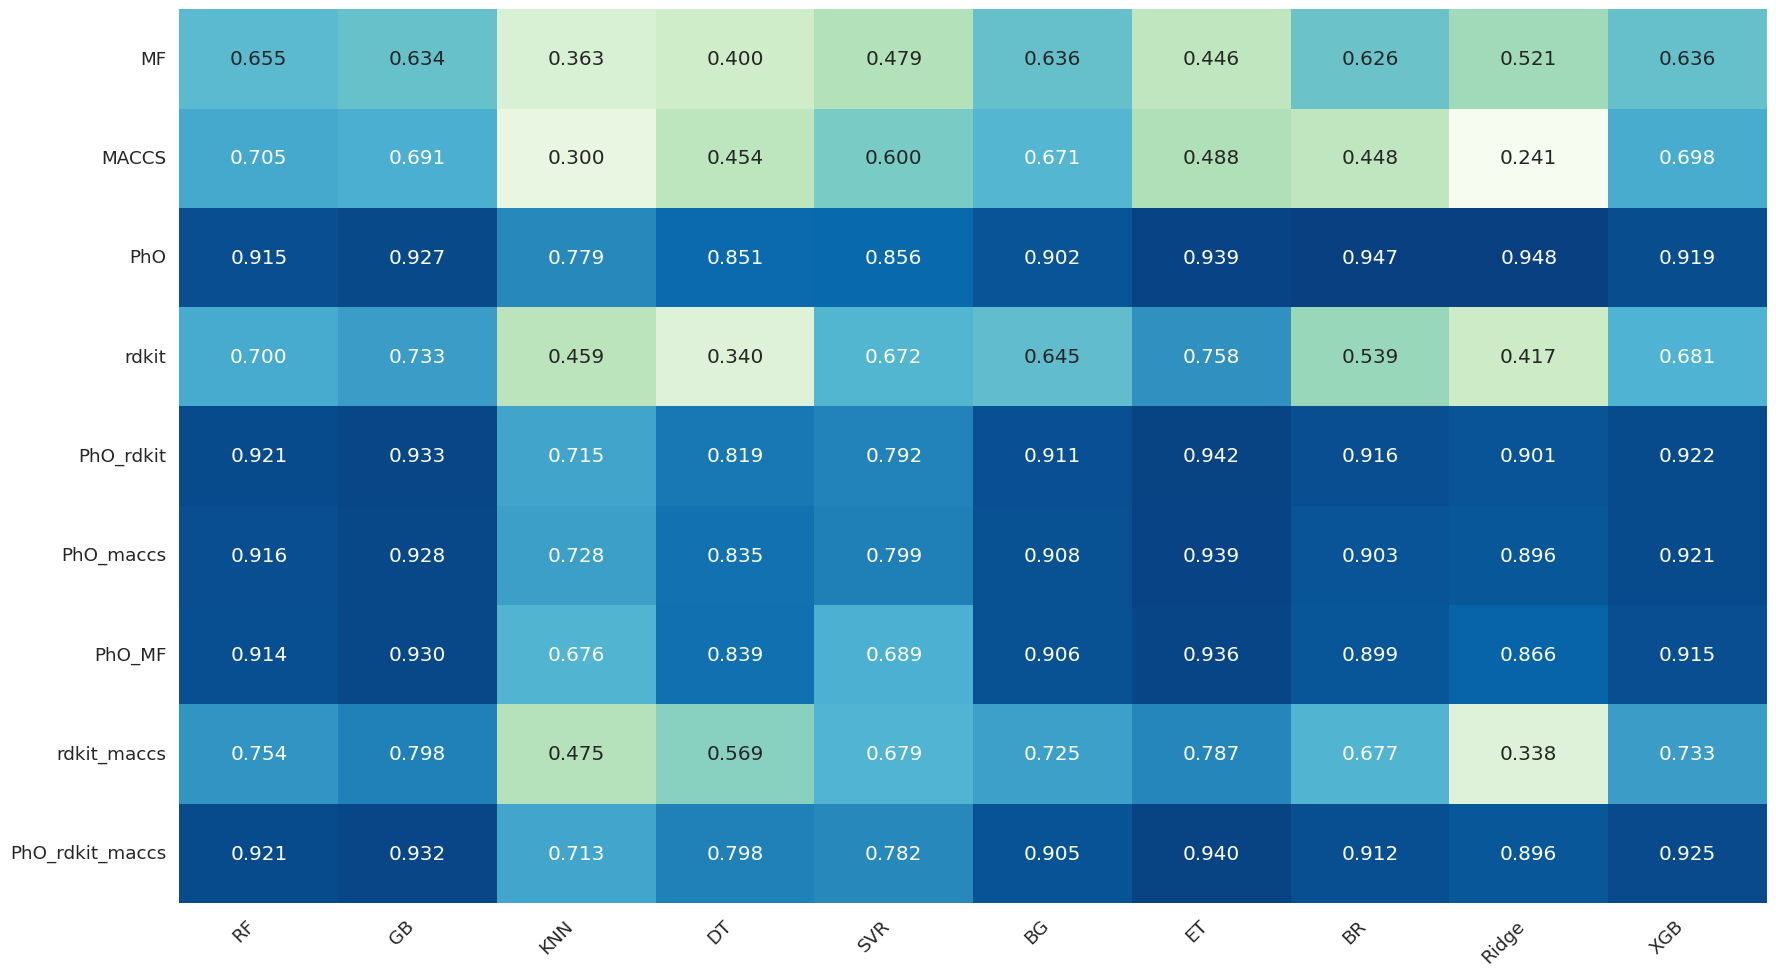

In [11]:
model_names = ['RF', 'GB', 'KNN', 'DT', 'SVR', 'BG', 'ET', 'BR', 'Ridge', 'XGB']
desc_names = list(datasets.keys())
r2_map = np.zeros((len(desc_names),len(model_names)))
r2_min_value = 0

for i, m in enumerate(model_names):
    for j, d in enumerate(desc_names):
            r2_map[j, i] = max(performance_result[(m,d)][1], r2_min_value)

fig = plt.figure(figsize=(18, 10))
sns.set(font_scale=1.6) 
ax = sns.heatmap(r2_map, annot=True, fmt='.3f', xticklabels=model_names, yticklabels=desc_names, cmap='GnBu',cbar=False)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./result/heatmap.tif', dpi=600)  
plt.savefig('./result/heatmap.png',dpi = 600)
plt.show()

# Validate Model Extrapolativa Ability

Identify the optimal machine learning model for every descriptor

Since MAE contains the maximum value in LR, the median and quartile values are extracted to obtain the optimal combination, while considering the importance of R and MAE as 6:4, and score it.

The interquartile range is an important statistic that describes the variability of data and indicates the spread of the 50% of the data. It is the difference between the upper quartile (Q3, the smallest value of the largest 25% of all values in the) and the lower quartile (Q1, the largest value of the smallest 25% of all values in the data). The interquartile range helps identify outliers provides a way to assess the variability of the data by excluding the influence of outliers. Values in the data that exceed Q3 plus 1.5 times the IQR or are Q1 minus 1.5 times the IQR are often considered potential outliers.

In [13]:
import numpy as np

performance_result = np.load('./result/models_descs_screening_10_fold_new.npy', allow_pickle=True).item()

model_names = ['RF', 'GB', 'KNN', 'DT', 'SVR',  'BG', 'ET', 'BR',  'Ridge', 'XGB']

all_combinations = list(performance_result.keys())

best_model_for_specific_desc = []

mae_values = np.array([performance_result[key][0] for key in all_combinations if performance_result[key][0] < 1e10])  
median_mae = np.median(mae_values)
iqr_mae = np.percentile(mae_values, 75) - np.percentile(mae_values, 25)

w_r2 = 0.6
w_mae = 0.4
r2_threshold = 0.80


for desc_name in set(desc for _, desc in all_combinations):
    best_score = -np.inf
    best_model_entry = None
    for item in all_combinations:
        if item[1] == desc_name:
            mae, r2 = performance_result[item][0], performance_result[item][1]
            
            if r2 > r2_threshold and mae < 1e10: 
                normalized_mae = (median_mae - mae) / iqr_mae  
                score = w_r2 * r2 + w_mae * normalized_mae 
                if score > best_score:
                    best_score = score
                    best_model_entry = [item, r2]
    if best_model_entry:
        best_model_for_specific_desc.append(best_model_entry)

print(best_model_for_specific_desc)


[[('ET', 'PhO_maccs'), 0.9390961651437587], [('ET', 'PhO_MF'), 0.9360555165436395], [('ET', 'PhO_rdkit'), 0.9417082341550568], [('ET', 'PhO_rdkit_maccs'), 0.9402835557576237], [('BR', 'PhO'), 0.9474255096005846]]


In [14]:
import numpy as np

performance_result = np.load('./result/models_descs_screening_10_fold_new.npy', allow_pickle=True).item()

model_names = ['RF', 'GB', 'KNN', 'DT', 'SVR', 'BG', 'ET', 'BR',  'Ridge', 'XGB']

best_desc_for_specific_model = {}

mae_values = [performance_result[key][0] for key in performance_result.keys() if performance_result[key][0] < 1e10]  # 过滤极端值
median_mae = np.median(mae_values)
iqr_mae = np.percentile(mae_values, 75) - np.percentile(mae_values, 25)

w_r2 = 0.6
w_mae = 0.4

r2_threshold = 0.80

for model in model_names:
    best_score = -np.inf
    best_descriptor = None

    for (m, desc), values in performance_result.items():
        if m == model:
            r2 = values[1]  
            mae = values[0] 
            if r2 > r2_threshold and mae < 1e10:
                normalized_mae = (median_mae - mae) / iqr_mae  
                score = w_r2 * r2 + w_mae * normalized_mae 
                if score > best_score:
                    best_score = score
                    best_descriptor = (desc, r2)
    if best_descriptor:
        best_desc_for_specific_model[model] = best_descriptor

best_desc_for_specific_model_list = [
    (model, desc, r2) for model, (desc, r2) in best_desc_for_specific_model.items()
]
print(best_desc_for_specific_model_list)


[('RF', 'PhO_rdkit_maccs', 0.9208235708793083), ('GB', 'PhO_rdkit', 0.93338530946829), ('DT', 'PhO', 0.8514259917454625), ('SVR', 'PhO', 0.8561700264993992), ('BG', 'PhO_rdkit', 0.9107769753693746), ('ET', 'PhO_rdkit_maccs', 0.9402835557576237), ('BR', 'PhO', 0.9474255096005846), ('Ridge', 'PhO', 0.9476803313059964), ('XGB', 'PhO_rdkit_maccs', 0.9252063633377633)]


In [15]:
oos_performance = {}
from utils.ModelTraining import init_model, oos_fit_pred, cv_fit_pred, feature_selection, model_evaluation
import importlib
import utils.ModelTraining 

importlib.reload(utils.ModelTraining)
from utils.ModelTraining import init_model, oos_fit_pred, cv_fit_pred, feature_selection, model_evaluation


In [16]:
oos_x = scaler.transform(X.iloc[test_index])
oos_y = y.iloc[test_index]

In [18]:
model_name = 'ET'
desc_name = 'PhO_rdkit_maccs'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [21]:
model_name = 'ET'
desc_name = 'PhO_maccs'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [19]:
model_name = 'ET'
desc_name = 'PhO_rdkit'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [20]:
model_name = 'ET'
desc_name = 'PhO_MF'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [17]:
model_name = 'BR'
desc_name = 'PhO'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [28]:
model_name = 'XGB'
desc_name = 'PhO_rdkit_maccs'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [27]:
model_name = 'Ridge'
desc_name = 'PhO'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [26]:
model_name = 'BG'
desc_name = 'PhO_rdkit'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [25]:
model_name = 'SVR'
desc_name = 'PhO'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [22]:
model_name = 'RF'
desc_name = 'PhO_rdkit_maccs'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [23]:
model_name = 'GB'
desc_name = 'PhO_rdkit'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


In [24]:
model_name = 'DT'
desc_name = 'PhO'

_, _, cv_mae, cv_r2, cv_pearson_r, _, _, oos_mae, oos_r2, oos_pearson_r = model_evaluation(
    X, y, X_scaled, y_train_val, oos_x, oos_y, best_params, model_name, desc_name, test_index,scaler, random_seed=random_seed)

oos_performance['%s/%s'%(model_name,desc_name)] = [oos_r2,oos_mae]


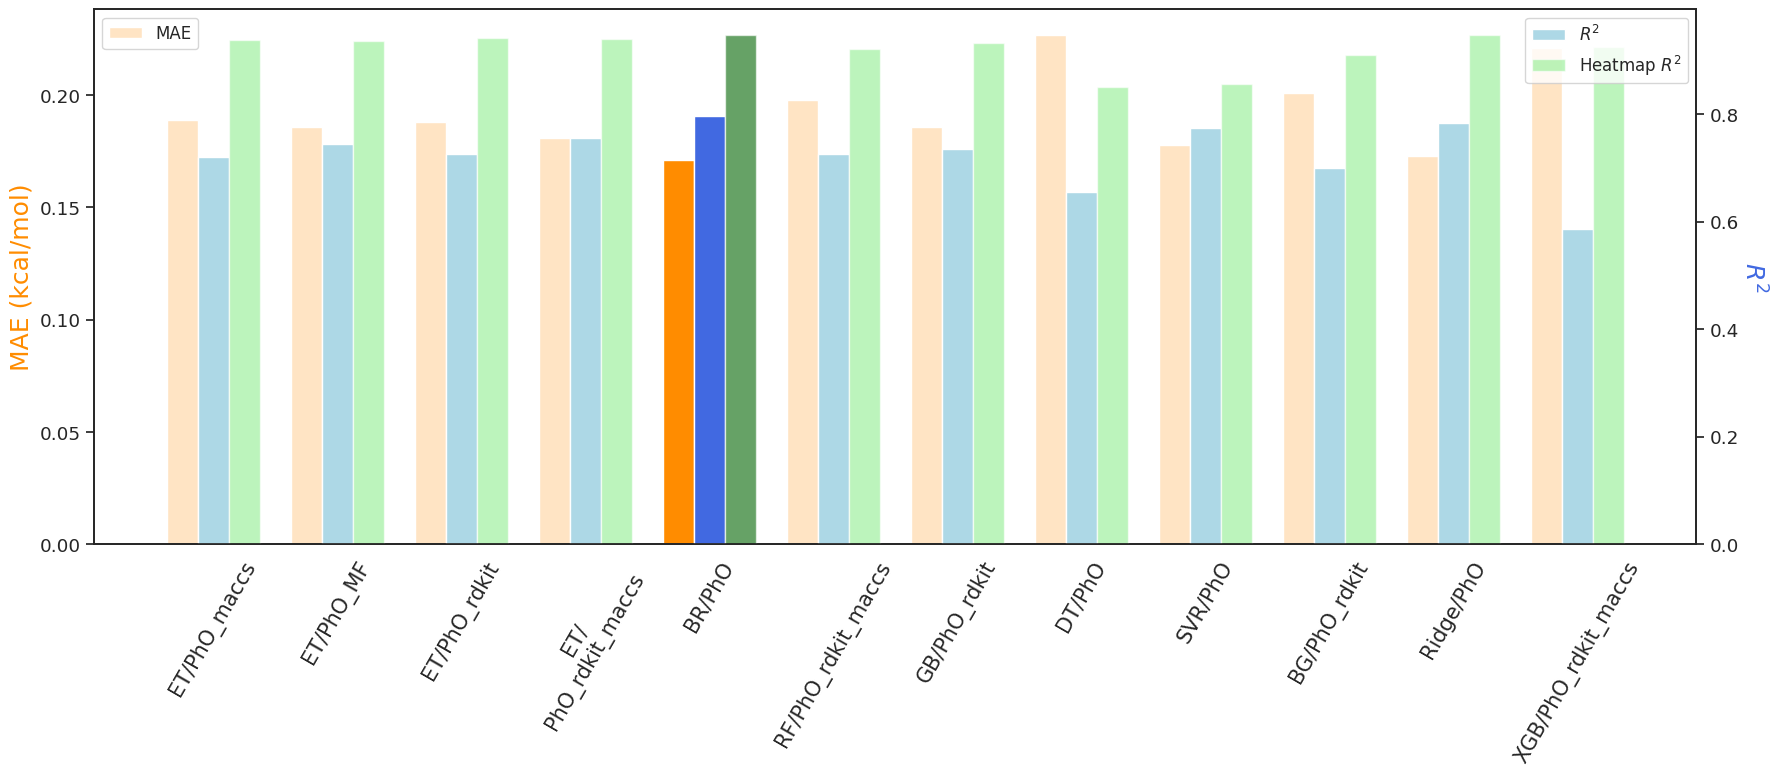

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import colors

sns.set_style('white')

performance_dict = {}

for model_desc_pair, _ in best_model_for_specific_desc:
    model, desc = model_desc_pair
    key = f'{model}/{desc}'
    if key in oos_performance and oos_performance[key][0] >= 0:
        performance_dict[key] = (oos_performance[key][0], oos_performance[key][1])

for model_desc_pair in best_desc_for_specific_model_list:
    model, desc, _ = model_desc_pair
    key = f'{model}/{desc}'
    if key in oos_performance and oos_performance[key][0] >= 0:
        performance_dict[key] = (oos_performance[key][0], oos_performance[key][1])

all_combinations = list(performance_dict.keys())
oos_r2_filtered = [item[0] for item in performance_dict.values()]
oos_mae_filtered = [item[1] for item in performance_dict.values()]

oos_r2_filtered_rounded = [round(value, 3) for value in oos_r2_filtered]
oos_mae_filtered_rounded = [round(value, 3) for value in oos_mae_filtered]

heatmap_r2 = []
for label in all_combinations:
    model_desc_pair = label.split('/')
    key_tuple = (model_desc_pair[0], model_desc_pair[1])
    
    if key_tuple in performance_result:
        heatmap_r2.append(round(performance_result[key_tuple][1], 3))  
    else:
        heatmap_r2.append(np.nan)

tickfontsize = 18
labelfontsize = 22

fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()

bar_width = 0.25  
indices = np.arange(len(all_combinations))

mae_colors = ['bisque', 'bisque', 'bisque', 'bisque', 'darkorange', 'bisque', 'bisque', 'bisque', 'bisque', 'bisque', 'bisque', 'bisque']  # 这里你可以根据需要修改颜色列表

r2_colors = ['lightblue', 'lightblue', 'lightblue', 'lightblue', 'royalblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue']  # 这里你可以根据需要修改颜色列表

heatmap_r2_colors = ['lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'darkgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen', 'lightgreen']  # 这里你可以根据需要修改颜色列表

ax1.bar(
    indices - bar_width, 
    oos_mae_filtered_rounded, 
    bar_width, 
    color=mae_colors, 
    label='MAE'
)

ax2.bar(
    indices, 
    oos_r2_filtered_rounded, 
    bar_width, 
    color=r2_colors,  
    label='$R^2$'
)

ax2.bar(
    indices + bar_width, 
    heatmap_r2, 
    bar_width, 
    color=heatmap_r2_colors,
    label='Heatmap $R^2$', 
    alpha=0.6
)

formatted_labels = []
for label in all_combinations:
    if label == 'XGB/PhO_rdkit_maccs':
        formatted_labels.append('XGB/\nPhO_rdkit_maccs')
    elif label == 'RF/PhO_rdkit_maccs':
        formatted_labels.append('RF/\nPhO_rdkit_maccs')
    elif label == 'ET/PhO_rdkit_maccs':
        formatted_labels.append('ET/\nPhO_rdkit_maccs')    
    else:
        formatted_labels.append(label)

ax1.set_xticks(indices)
ax1.set_xticklabels(formatted_labels, fontsize=tickfontsize, rotation=60, ha='center')

ax2.set_ylabel('$R^2$', fontsize=labelfontsize, color='royalblue', rotation=270, labelpad=20)
ax1.set_ylabel('MAE (kcal/mol)', fontsize=labelfontsize, color='darkorange')

# 添加图例
ax1.legend(loc='upper left', fontsize=16)
ax2.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.savefig('./result/combined_models_descs_with_separated_bars.png', dpi=600)
plt.show()
